# Convolutional Neural Network With PyTorch
----------------------------------------------

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

import math
import random

from PIL import Image, ImageOps, ImageEnhance
import numbers

import matplotlib.pyplot as plt
%matplotlib inline

## Explore the Data

In [2]:
train_df = pd.read_csv('../input/train.csv')

n_train = len(train_df)
n_pixels = len(train_df.columns) - 1
n_class = len(set(train_df['label']))

print('Number of training samples: {0}'.format(n_train))
print('Number of training pixels: {0}'.format(n_pixels))
print('Number of classes: {0}'.format(n_class))

Number of training samples: 42000
Number of training pixels: 784
Number of classes: 10


In [3]:
test_df = pd.read_csv('../input/test.csv')

n_test = len(test_df)
n_pixels = len(test_df.columns)

print('Number of train samples: {0}'.format(n_test))
print('Number of test pixels: {0}'.format(n_pixels))

Number of train samples: 28000
Number of test pixels: 784


### Display some images

9, 7, 5, 4, 3, 6, 3, 4


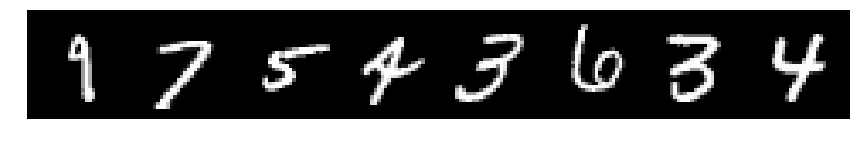

In [4]:
random_sel = np.random.randint(n_train, size=8)

grid = make_grid(torch.Tensor((train_df.iloc[random_sel, 1:].as_matrix()/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=8)
plt.rcParams['figure.figsize'] = (16, 2)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
print(*list(train_df.iloc[random_sel, 0].values), sep = ', ')

### Histogram of the classes

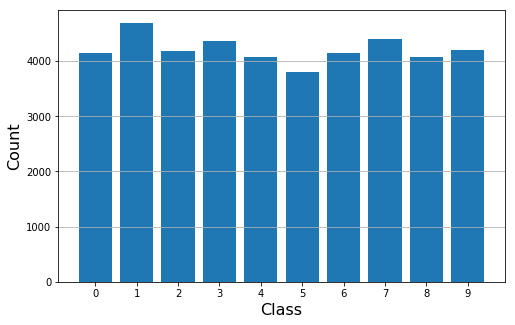

In [5]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.bar(train_df['label'].value_counts().index, train_df['label'].value_counts())
plt.xticks(np.arange(n_class))
plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.grid('on', axis='y')

## Data Loader

In [6]:
class MNIST_data(Dataset):
    """MNIST dtaa set"""
    
    def __init__(self, file_path, 
                 transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), 
                     transforms.Normalize(mean=(0.5,), std=(0.5,))])
                ):
        
        df = pd.read_csv(file_path)
        
        if len(df.columns) == n_pixels:
            # test data
            self.X = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
            
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

### Random Rotation Transformation
Randomly rotate the image. Available in upcoming torchvision but not now.

In [7]:
class RandomRotation(object):
    """
    https://github.com/pytorch/vision/tree/master/torchvision/transforms
    Rotate the image by angle.
    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
        resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
        expand (bool, optional): Optional expansion flag.
            If true, expands the output to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
        center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
    """

    def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = np.random.uniform(degrees[0], degrees[1])

        return angle

    def __call__(self, img):
        """
            img (PIL Image): Image to be rotated.
        Returns:
            PIL Image: Rotated image.
        """
        
        def rotate(img, angle, resample=False, expand=False, center=None):
            """Rotate the image by angle and then (optionally) translate it by (n_columns, n_rows)
            Args:
            img (PIL Image): PIL Image to be rotated.
            angle ({float, int}): In degrees degrees counter clockwise order.
            resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
            expand (bool, optional): Optional expansion flag.
            If true, expands the output image to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
            center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
            """
                
            return img.rotate(angle, resample, expand, center)

        angle = self.get_params(self.degrees)

        return rotate(img, angle, self.resample, self.expand, self.center)

### Random Vertical and Horizontal Shift

In [8]:
class RandomShift(object):
    def __init__(self, shift):
        self.shift = shift
        
    @staticmethod
    def get_params(shift):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        hshift, vshift = np.random.uniform(-shift, shift, size=2)

        return hshift, vshift 
    def __call__(self, img):
        hshift, vshift = self.get_params(self.shift)
        
        return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)
    

## Load the Data into Tensors
For the training set, apply random rotation within the range of (-45, 45) degrees, shift by (-3, 3) pixels
and normalize pixel values to [-1, 1].  For the test set, only apply nomalization.

In [10]:
batch_size = 64

train_dataset = MNIST_data('../input/train.csv', transform= transforms.Compose(
                            [transforms.ToPILImage(), RandomRotation(degrees=45), RandomShift(3),
                             transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))]))
test_dataset = MNIST_data('../input/test.csv')


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, shuffle=False)

### Visualize the Transformations

/home/jychang/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


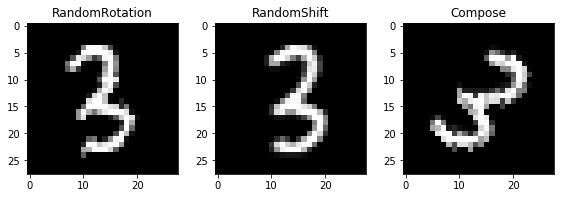

In [11]:
rotate = RandomRotation(45)
shift = RandomShift(3)
composed = transforms.Compose([RandomRotation(45),
                               RandomShift(3)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = transforms.ToPILImage()(train_df.iloc[65,1:].reshape((28,28)).astype(np.uint8)[:,:,None])
for i, tsfrm in enumerate([rotate, shift, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    ax.imshow(np.reshape(np.array(list(transformed_sample.getdata())), (-1,28)), cmap='gray')    

plt.show()

## Network Structure

In [12]:
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
          
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 3 * 3, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, 10),
        )
          
        for m in self.features.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
                

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x     

In [13]:
model = Net()

optimizer = optim.Adam(model.parameters(), lr=0.003)

criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

## Training and Evaluation

In [14]:
def train(epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        if batch_idx% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [15]:
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).data[0]

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

### Train the network

In [16]:
for epoch in range(30):
    train(epoch)
    evaluate(train_loader)

Train Epoch: 0 [0/42000 (0%)]	Loss: 5.358752
Train Epoch: 0 [6400/42000 (15%)]	Loss: 1.396061
Train Epoch: 0 [12800/42000 (30%)]	Loss: 0.924599
Train Epoch: 0 [19200/42000 (46%)]	Loss: 0.878184
Train Epoch: 0 [25600/42000 (61%)]	Loss: 0.378729
Train Epoch: 0 [32000/42000 (76%)]	Loss: 0.490264
Train Epoch: 0 [38400/42000 (91%)]	Loss: 0.357702

Average loss: 0.1928, Accuracy: 39668/42000 (94%)

Train Epoch: 1 [0/42000 (0%)]	Loss: 0.277282
Train Epoch: 1 [6400/42000 (15%)]	Loss: 0.181907
Train Epoch: 1 [12800/42000 (30%)]	Loss: 0.164069
Train Epoch: 1 [19200/42000 (46%)]	Loss: 0.389159
Train Epoch: 1 [25600/42000 (61%)]	Loss: 0.339012
Train Epoch: 1 [32000/42000 (76%)]	Loss: 0.298699
Train Epoch: 1 [38400/42000 (91%)]	Loss: 0.249344

Average loss: 0.1771, Accuracy: 39901/42000 (95%)

Train Epoch: 2 [0/42000 (0%)]	Loss: 0.580661
Train Epoch: 2 [6400/42000 (15%)]	Loss: 0.088132
Train Epoch: 2 [12800/42000 (30%)]	Loss: 0.311965
Train Epoch: 2 [19200/42000 (46%)]	Loss: 0.204177
Train Epoch: 2

Train Epoch: 20 [32000/42000 (76%)]	Loss: 0.006847
Train Epoch: 20 [38400/42000 (91%)]	Loss: 0.019286

Average loss: 0.0402, Accuracy: 41576/42000 (99%)

Train Epoch: 21 [0/42000 (0%)]	Loss: 0.156475
Train Epoch: 21 [6400/42000 (15%)]	Loss: 0.105724
Train Epoch: 21 [12800/42000 (30%)]	Loss: 0.066454
Train Epoch: 21 [19200/42000 (46%)]	Loss: 0.073228
Train Epoch: 21 [25600/42000 (61%)]	Loss: 0.054301
Train Epoch: 21 [32000/42000 (76%)]	Loss: 0.006316
Train Epoch: 21 [38400/42000 (91%)]	Loss: 0.086152

Average loss: 0.0363, Accuracy: 41585/42000 (99%)

Train Epoch: 22 [0/42000 (0%)]	Loss: 0.086656
Train Epoch: 22 [6400/42000 (15%)]	Loss: 0.053634
Train Epoch: 22 [12800/42000 (30%)]	Loss: 0.140414
Train Epoch: 22 [19200/42000 (46%)]	Loss: 0.013158
Train Epoch: 22 [25600/42000 (61%)]	Loss: 0.050386
Train Epoch: 22 [32000/42000 (76%)]	Loss: 0.165757
Train Epoch: 22 [38400/42000 (91%)]	Loss: 0.113012

Average loss: 0.0426, Accuracy: 41528/42000 (99%)

Train Epoch: 23 [0/42000 (0%)]	Loss: 0.0

## Prediction on Test Set

In [17]:
def prediciton(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = Variable(data, volatile=True)
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = model(data)
        
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

In [18]:
test_pred = prediciton(test_loader)

In [19]:
out_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], test_pred.numpy()], 
                      columns=['ImageId', 'Label'])

In [20]:
out_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [21]:
out_df.to_csv('../output/vgg_sub2.csv', index=False)